<a href="https://colab.research.google.com/github/JGuibone/prototype-Info-Manage/blob/master/Thesis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pip Installs

In [ ]:
%pip install faiss-gpu
%pip install -U sentence-transformers
%pip install torch
%pip install pandas
%pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 5.8 MB 76.8 MB/s 
     |████████████████████████████████| 1.3 MB 52.8 MB/s 
     |████████████████████████████████| 182 kB 62.8 MB/s 
     |████████████████████████████████| 7.6 MB 58.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e9718484543c245ac34769db1c39d0101fa7360b789e246276d8f75b4381f675
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://

#Imports and load needed data for notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import faiss
import torch
import tqdm
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, util
from scipy.spatial.distance import cdist as scipy_cdist
import matplotlib.pyplot as plt
from matplotlib import figure
import os

np.random.seed(0)

In [ ]:
train_examples = []
with open('/content/drive/MyDrive/Colab_Notebooks/generated_queriestest.tsv') as fIn:
    for line in fIn:
        try:
          query, paragraph = line.strip().rsplit('\t', maxsplit=1)
          train_examples.append([query, paragraph])
        except:
          continue

In [ ]:
contents = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/documentCSV.csv', usecols=['NAME_DOCUMENT', 'CONTENT'])
contents.reset_index(drop=True, inplace=True)

In [ ]:
array = np.array(train_examples)
column_values = ['QUESTIONS','PARAGRAPHS']

testDataFrame = pd.DataFrame(data = array, 
                  index = range(0,len(train_examples)), 
                  columns = column_values)

#Load Model

## msmarco-distilbert-base-dot-prod-v3 [link text](https://huggingface.co/sentence-transformers/msmarco-distilbert-base-dot-prod-v3)

###msmarco-distilbert-base-dot-prod-v3 [NOT Fine-tuned for corpus data]

In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3', device=torch_device)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

###msmarco-distilbert-base-dot-prod-v3 [Fine-tuned for corpus data]

In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('/content/drive/MyDrive/Colab_Notebooks/msmarco-distilbert-base-dot-prod-v3-FineTuned-ACLC', device=torch_device)

##msmarco-distilbert-base-v4 Pre-Trained  [link text](https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v4)

###msmarco-distilbert-basev4 Pre-trained [NOT finetuned]

In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('msmarco-distilbert-base-v4', device=torch_device)

###msmarco-distilbert-base-v4 [Fine-tuned]

In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('/content/drive/MyDrive/Colab_Notebooks/DistilBert-model-FineTuned-aclc', device=torch_device) 

#Test Module

In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('/content/drive/MyDrive/Colab_Notebooks/BaseBert-model-Untrained', device=torch_device)

In [ ]:
print(len(train_examples))

30875


#TEST Document Embedding

In [ ]:
testCorpusForAsymetric = contents
testSenteces = testCorpusForAsymetric['CONTENT'].tolist()
import ast
nestedList = []
for line in testSenteces:
  nestedList.append(ast.literal_eval(line))

testSentecesTest = nestedList

In [ ]:
joinedList = [' '.join(sentence) for sentence in testSentecesTest]

In [ ]:
documents_embeddings = model.encode(joinedList, device=torch_device, show_progress_bar=True, batch_size=32)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

#EMBED Content 2 Vect

In [ ]:
documents_embeddings = model.encode(contents.CONTENT.tolist(), device=torch_device, show_progress_bar=True, batch_size=32)

NameError: ignored

In [ ]:
torch.cuda.is_available()

True

Query and Data Retrieval Examples

#Brute Force Searching using Cosine Similarity

In [ ]:
query = 'what is error correction code in data protocol'

query_embed = model.encode([query], device=torch_device)

start = timer()

similarities = 1 - scipy_cdist(query_embed, documents_embeddings, 'cosine')

similarities = np.around(similarities, decimals=2)

end = timer()

print(f"Finished in {(end - start): .4f} seconds.")

best_sim_idx = np.argmax(similarities[0])
most_sim_doc_content = contents.loc[best_sim_idx].CONTENT[:500]
most_sim_doc_content_similar = similarities[0].max()

print(f'Score: "{most_sim_doc_content_similar}"')
print(f'Most similar document to the query: "{most_sim_doc_content}"')

Finished in  0.0013 seconds.
Score: "0.63"
Most similar document to the query: "[' WEEK 8: Error Detection and Correction in Semiconductor Memories, Advanced  DRAM Organization  1 | P a g e   COMPUTER ORGANIZATION AND ARCHITECTURE Objectives At the end of the lesson the learner will be able to Identify the error detection and correction in semiconductor memories Define the DRAM Identify the new enhancements in DRAM architectures ERROR DETECTION AND CORRECTION IN SEMICONDUCTOR MEMORIES Error detection codes   are used to detect the error(s) present in the received data (bit "


#Using Faiss

In [ ]:
n_dimensions = documents_embeddings.shape[1]

documents_embeddings = np.array([embedding for embedding in documents_embeddings]).astype("float32")
#index = faiss.IndexFlatIP(n_dimensions)
#index = faiss.IndexIDMap(index)

index_emb = faiss.IndexFlatIP(n_dimensions)
index_emb.add(documents_embeddings)

#index.add_with_ids(documents_embeddings, np.array(range(0, len(contents))))

#res = faiss.StandardGpuResources()
#index = faiss.index_cpu_to_gpu(res, 0, index)

def find_data(dataframe_idx):
  info = contents.iloc[dataframe_idx]
  meta_dict = dict()
  meta_dict['NAME-OF-DOCUMENT'] = info['NAME_DOCUMENT']
  meta_dict['CONTENT'] = info['CONTENT']
  
  return meta_dict

def search(query, top_k, index, model):

  start = timer()

  query_vector = model.encode([query], device=torch_device)
  top_k = index.search(query_vector, top_k)

  end = timer()

  print(f'Finished in "{(end-start):.4f} seconds."')

  top_k_ids = top_k[1].tolist()[0]
  top_k_ids = list(np.unique(top_k_ids))
  results =  [find_data(idx) for idx in top_k_ids]

  return results

#TEST SEARCH

In [ ]:
query="what is error correction code in data protocol"
query_vector = model.encode([query], device=torch_device)
#results=index.search(query_vector, 3)
#print("\n")
#for result in results:
#    print('\t',result)



top_k = index_emb.search(query_vector, 3)
locateFile = top_k[1][0]
filesLoc = [find_data(idx) for idx in locateFile]
for i in filesLoc:
  print(f"filename: {i['NAME-OF-DOCUMENT']} \n Content: {i['CONTENT'][:100]} \n")
print('=============================================')
print(locateFile)

filename: W8_Error_Detection_and_Correction_in_Semiconductor_Memories_Advanced_DRAM_Organization.pdf 
 Content: [' WEEK 8: Error Detection and Correction in Semiconductor Memories, Advanced  DRAM Organization  1  

filename: Module_1_introduction.pdf 
 Content: [' CS-6202 : ALGORITHMS and COMPLEXITY  Module 1 Introduction Objectives At the end of the lesson, t 

filename: Mod1__Introduction.pptx 
 Content: [' WEEK 1 Introduction to Algorithms & Complexity WEEK 1 Introduction to Algorithms & Complexity CS  

[195  96  86]


#Evaluation Methods

###Example for getting Cosine Similarity and Dot-Product

Cosine Similarity test

In [ ]:
queryEmb = model.encode('The boy playes with a blue ball.', device=torch_device)
paraEmb = model.encode('The boy playes with a red ball.', device=torch_device)
EvalCosine = util.cos_sim(queryEmb,paraEmb)
EvalDot = util.dot_score(queryEmb,paraEmb)
print(f"Cosine: {EvalCosine}, Dot-Prod: {EvalDot}")

Cosine: tensor([[0.8060]]), Dot-Prod: tensor([[130.3101]])


In [ ]:
for i in range(200,220):
  testqueryEmb = model.encode([testDataFrame['QUESTIONS'][i]], device=torch_device)
  testparaEmb = model.encode([testDataFrame['PARAGRAPHS'][i]], device=torch_device)
  valOfcos = util.cos_sim(testqueryEmb,testparaEmb)
  valOfdot = util.dot_score(testqueryEmb,testparaEmb)
  print(f"num: {i}, Cosine: {valOfcos}, Dot-Prod: {valOfdot} '\n'")

num: 200, Cosine: tensor([[0.8668]]), Dot-Prod: tensor([[147.0608]]) '
'
num: 201, Cosine: tensor([[0.3927]]), Dot-Prod: tensor([[64.6111]]) '
'
num: 202, Cosine: tensor([[0.7573]]), Dot-Prod: tensor([[129.4975]]) '
'
num: 203, Cosine: tensor([[0.8524]]), Dot-Prod: tensor([[148.4500]]) '
'
num: 204, Cosine: tensor([[0.4380]]), Dot-Prod: tensor([[75.2002]]) '
'
num: 205, Cosine: tensor([[0.6286]]), Dot-Prod: tensor([[92.2821]]) '
'
num: 206, Cosine: tensor([[0.4349]]), Dot-Prod: tensor([[69.2585]]) '
'
num: 207, Cosine: tensor([[0.4787]]), Dot-Prod: tensor([[77.0893]]) '
'
num: 208, Cosine: tensor([[0.5557]]), Dot-Prod: tensor([[84.0790]]) '
'
num: 209, Cosine: tensor([[0.4116]]), Dot-Prod: tensor([[65.0932]]) '
'
num: 210, Cosine: tensor([[0.6424]]), Dot-Prod: tensor([[97.2625]]) '
'
num: 211, Cosine: tensor([[0.6065]]), Dot-Prod: tensor([[99.9791]]) '
'
num: 212, Cosine: tensor([[0.6497]]), Dot-Prod: tensor([[102.1670]]) '
'
num: 213, Cosine: tensor([[0.4884]]), Dot-Prod: tensor([[82.

#Now to Automate Query and Scoring

##msmarco-distilbert-base-dot-prod-v3 with Matplotlab Diagram

In [ ]:
listOfcos = []
listOfdot = []

for i in range(len(testDataFrame)):
  queryEmb = model.encode([testDataFrame['QUESTIONS'][i]], device=torch_device)
  paraEmb = model.encode([testDataFrame['PARAGRAPHS'][i]], device=torch_device)
  top_k = index_emb.search(queryEmb, 1)
  numk = top_k[1][0][0]
  reconEmb = index_emb.reconstruct(int(numk))
  listOfcos.append(util.cos_sim(reconEmb,paraEmb))
  listOfdot.append(util.dot_score(reconEmb,paraEmb))

In [ ]:
floatOfCos = [round(float(x),5) for x in listOfcos]
floatOfDot = [round(float(x),5) for x in listOfdot]

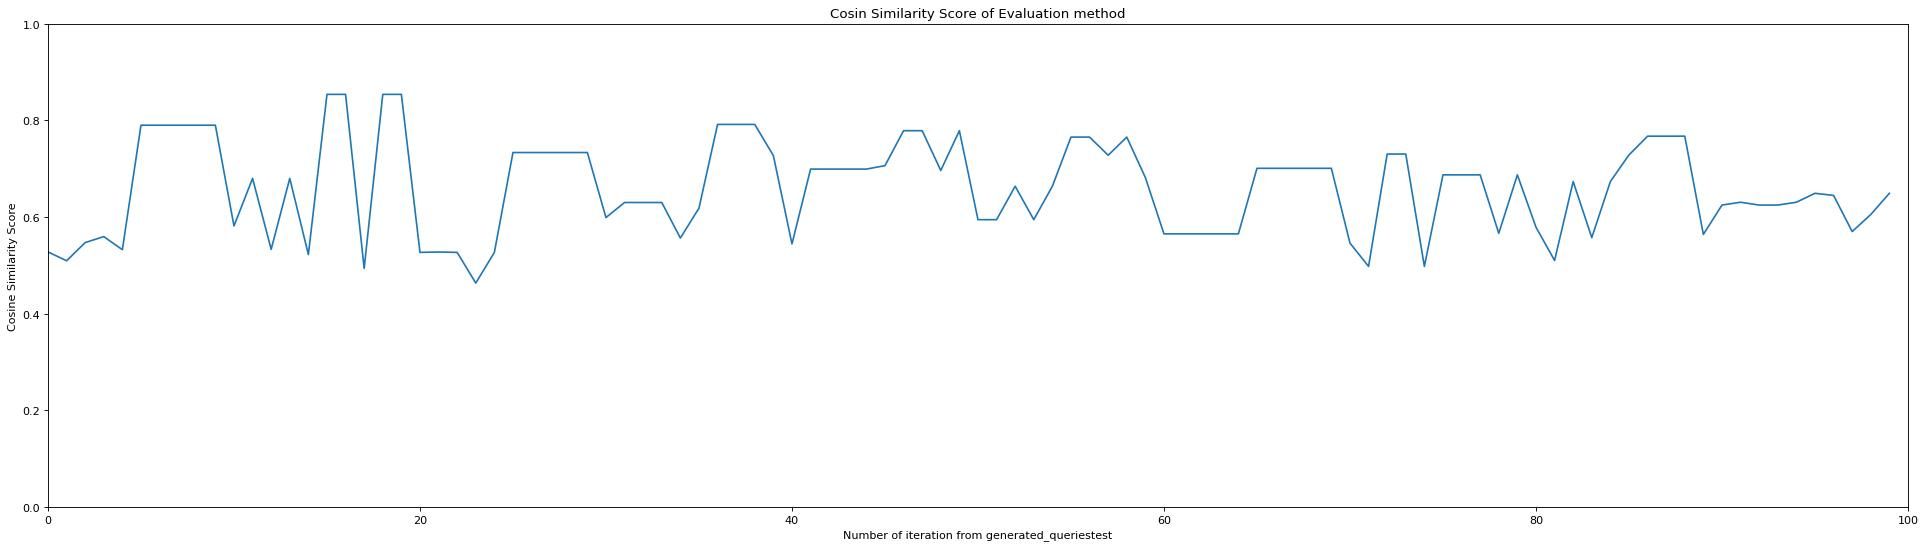

Average Cosine Similarity Score of first 100 iteration: 0.6590662.


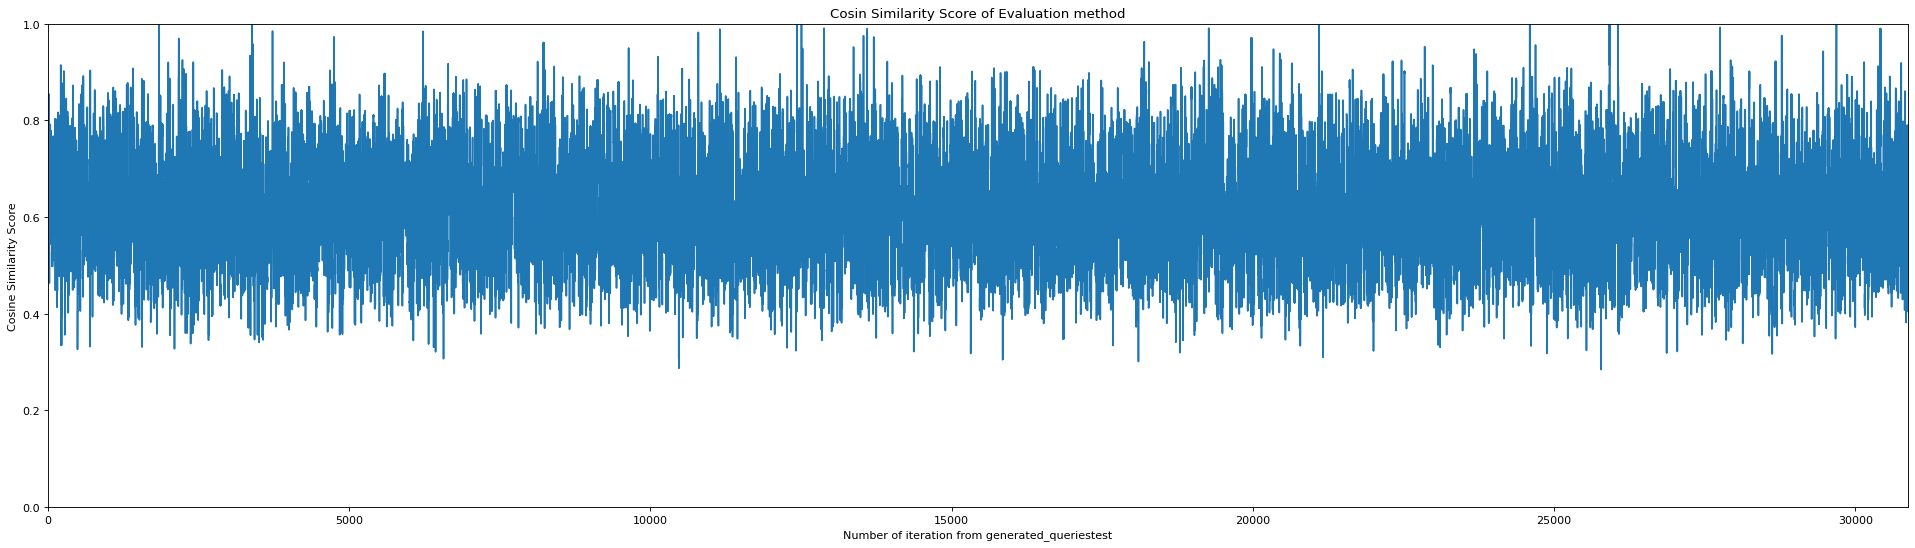

Average Cosine Similarity Score of full iteration: 0.63548215.
min of Data: 0.28426	 the mean of data: 0.63548215	 the max of the Data: 1.0.


(array([  73.,  718., 3162., 6013., 6712., 5932., 4537., 2851.,  730.,
         147.]),
 array([0.28426 , 0.355834, 0.427408, 0.498982, 0.570556, 0.64213 ,
        0.713704, 0.785278, 0.856852, 0.928426, 1.      ]),
 <a list of 10 Patch objects>)

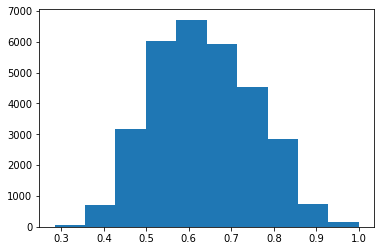

In [ ]:
pltCos,pltDot = plt,plt


pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,100)
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos[:100])
pltCos.show()

average = round(sum(floatOfCos[:100])/100, 8)

print(f"Average Cosine Similarity Score of first 100 iteration: {average}.")
print('='*32)

pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,len(floatOfCos))
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos)
pltCos.show()

average = round(sum(floatOfCos)/len(floatOfCos), 8)

print(f"Average Cosine Similarity Score of full iteration: {average}.")
minData, meanData, maxData = min(floatOfCos),average,max(floatOfCos)
print(f"min of Data: {minData}\t the mean of data: {average}\t the max of the Data: {maxData}.")


print('='*32)
pltCos.hist(floatOfCos, orientation='vertical')

In [ ]:
from math import comb
print(len(floatOfCos))

Prob = comb()

30875
1225


##msmarco-distilbert-base-dot-prod-v3 [Finetuned] with Matplotlab Diagram

In [ ]:
listOfcos = []
listOfdot = []

for i in range(len(testDataFrame)):
  queryEmb = model.encode([testDataFrame['QUESTIONS'][i]], device=torch_device)
  paraEmb = model.encode([testDataFrame['PARAGRAPHS'][i]], device=torch_device)
  top_k = index_emb.search(queryEmb, 1)
  numk = top_k[1][0][0]
  reconEmb = index_emb.reconstruct(int(numk))
  listOfcos.append(util.cos_sim(reconEmb,paraEmb))
  listOfdot.append(util.dot_score(reconEmb,paraEmb))

In [ ]:
floatOfCos = [round(float(x),5) for x in listOfcos]
floatOfDot = [round(float(x),5) for x in listOfdot]

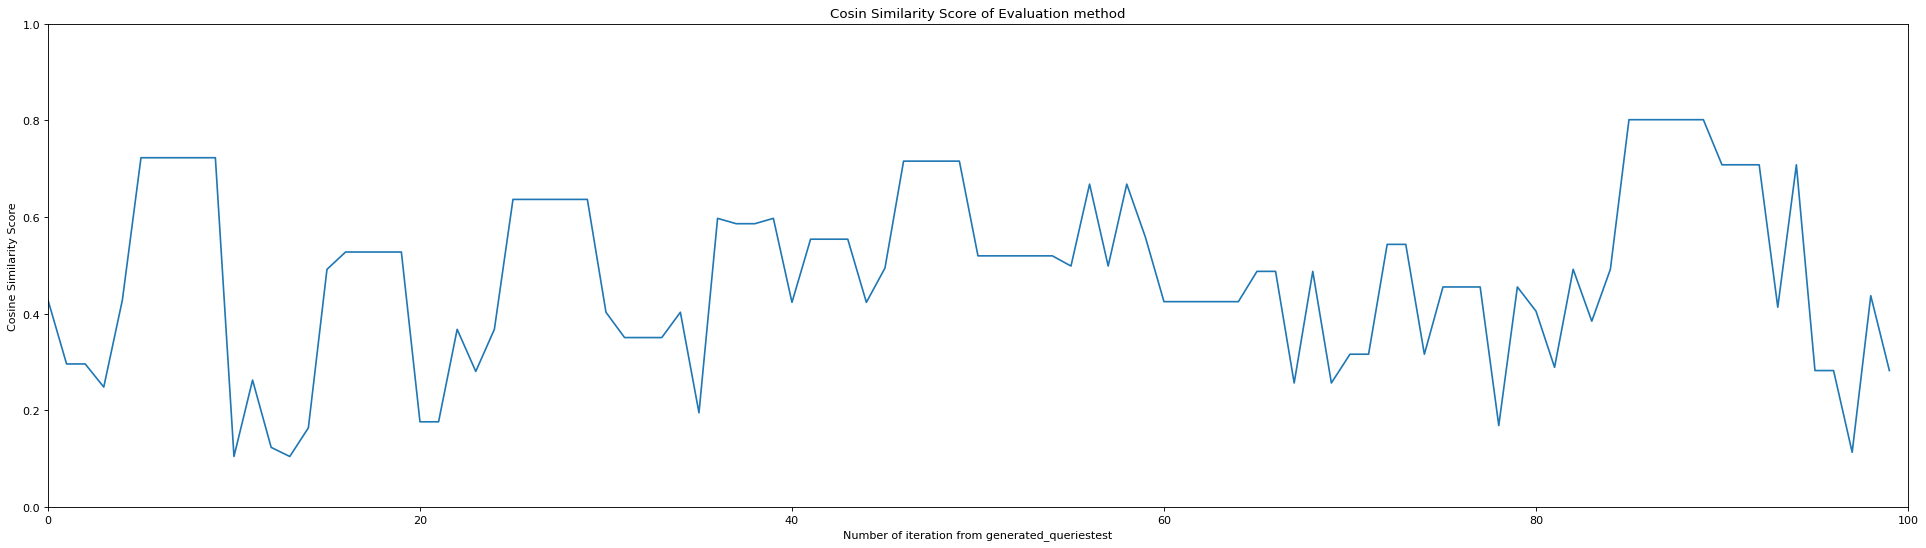

Average Cosine Similarity Score of first 100 iteration: 0.4781759.


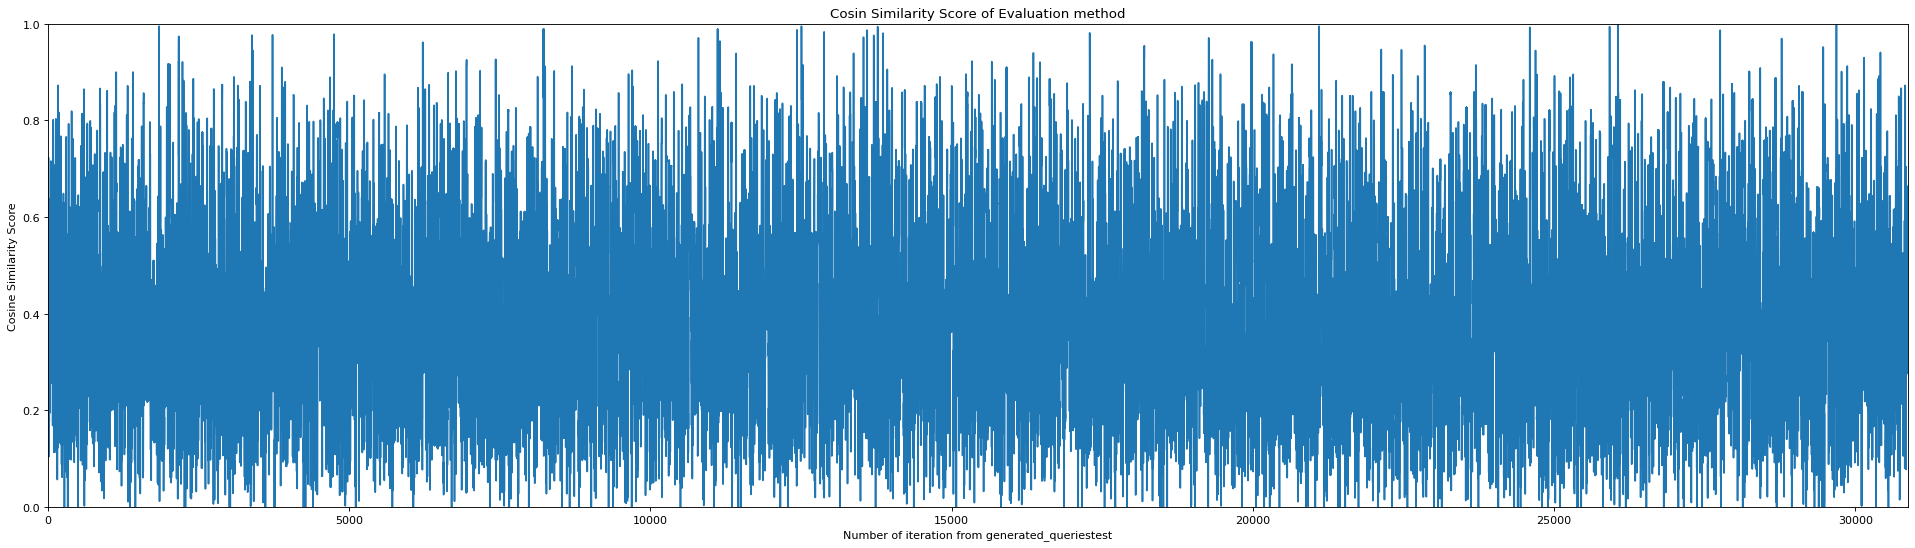

Average Cosine Similarity Score of full iteration: 0.42384205.
min of Data: -0.12847	 the mean of data: 0.42384205	 the max of the Data: 0.99768.


In [ ]:
pltCos,pltDot = plt,plt


pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,100)
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos[:100])
pltCos.show()

average = round(sum(floatOfCos[:100])/100, 8)

print(f"Average Cosine Similarity Score of first 100 iteration: {average}.")
print('='*32)

pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,len(floatOfCos))
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos)
pltCos.show()

average = round(sum(floatOfCos)/len(floatOfCos), 8)

print(f"Average Cosine Similarity Score of full iteration: {average}.")
minData, meanData, maxData = min(floatOfCos),average,max(floatOfCos)
print(f"min of Data: {minData}\t the mean of data: {average}\t the max of the Data: {maxData}.")


print('='*32)
#pltCos.hist(floatOfCos)

##msmarco-distilbert-baseV4 with Matplotlab Diagram

In [ ]:
listOfcos = []
listOfdot = []

for i in range(len(testDataFrame)):
  queryEmb = model.encode([testDataFrame['QUESTIONS'][i]], device=torch_device)
  paraEmb = model.encode([testDataFrame['PARAGRAPHS'][i]], device=torch_device)
  top_k = index_emb.search(queryEmb, 1)
  numk = top_k[1][0][0]
  reconEmb = index_emb.reconstruct(int(numk))
  listOfcos.append(util.cos_sim(reconEmb,paraEmb))
  listOfdot.append(util.dot_score(reconEmb,paraEmb))

In [ ]:
floatOfCos = [round(float(x),5) for x in listOfcos]
floatOfDot = [round(float(x),5) for x in listOfdot]

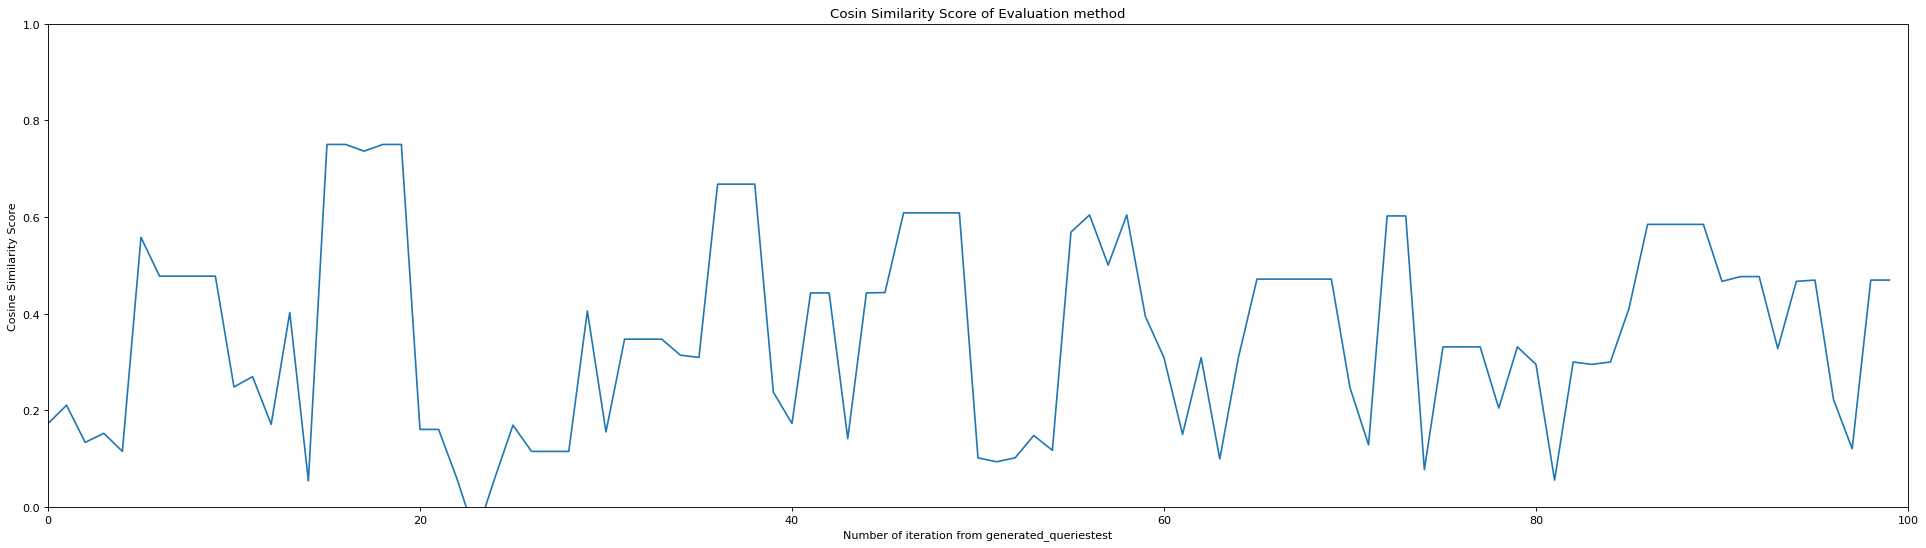

Average Cosine Similarity Score of first 100 iteration: 0.35912.


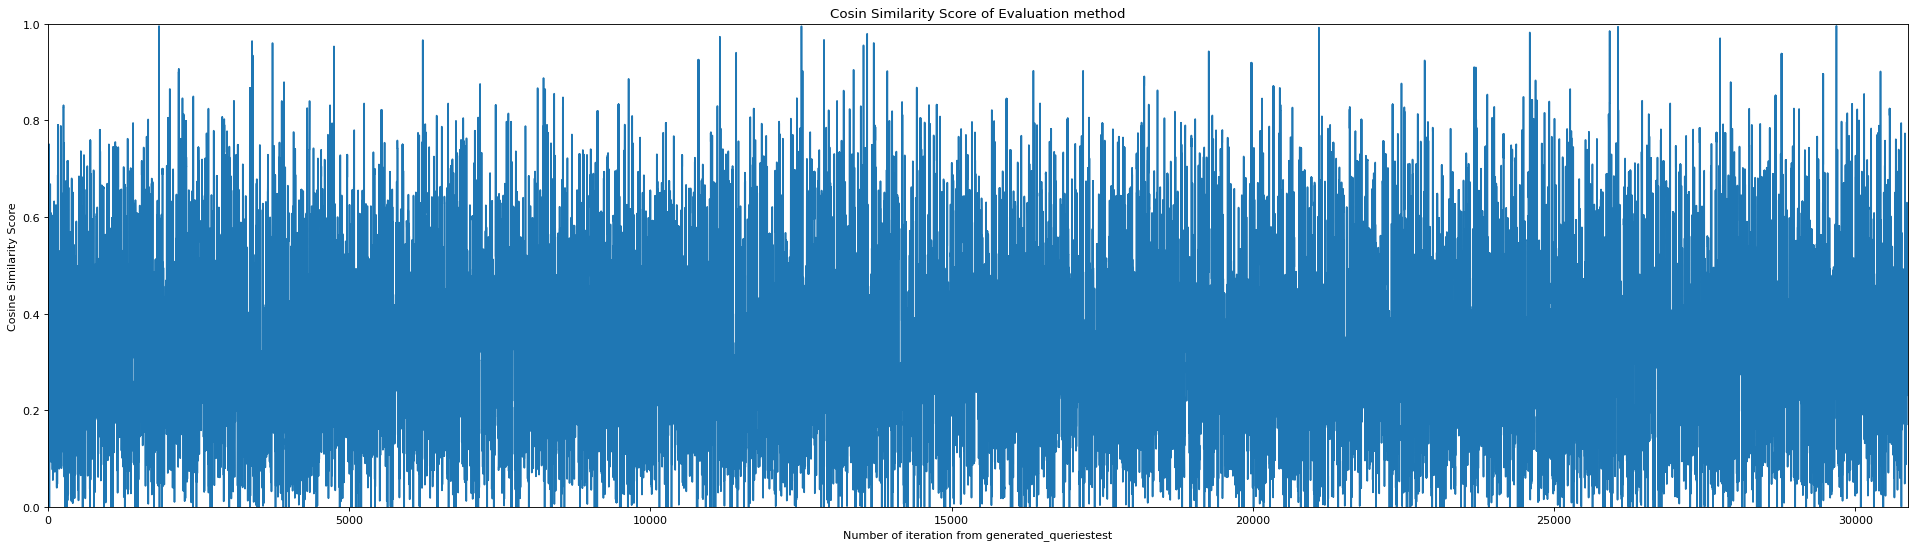

Average Cosine Similarity Score of full iteration: 0.36479539.
min of Data: -0.13363	 the mean of data: 0.36479539	 the max of the Data: 0.99538.


In [ ]:
pltCos,pltDot = plt,plt


pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,100)
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos[:100])
pltCos.show()

average = round(sum(floatOfCos[:100])/100, 8)

print(f"Average Cosine Similarity Score of first 100 iteration: {average}.")
print('='*32)

pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,len(floatOfCos))
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos)
pltCos.show()

average = round(sum(floatOfCos)/len(floatOfCos), 8)

print(f"Average Cosine Similarity Score of full iteration: {average}.")
minData, meanData, maxData = min(floatOfCos),average,max(floatOfCos)
print(f"min of Data: {minData}\t the mean of data: {average}\t the max of the Data: {maxData}.")


print('='*32)
#pltCos.hist(floatOfCos)

##msmarco-distilbert-baseV4 [Finetuned] with Matplotlab Diagram

In [ ]:
listOfcos = []
listOfdot = []

for i in range(len(testDataFrame)):
  queryEmb = model.encode([testDataFrame['QUESTIONS'][i]], device=torch_device)
  paraEmb = model.encode([testDataFrame['PARAGRAPHS'][i]], device=torch_device)
  top_k = index_emb.search(queryEmb, 1)
  numk = top_k[1][0][0]
  reconEmb = index_emb.reconstruct(int(numk))
  listOfcos.append(util.cos_sim(reconEmb,paraEmb))
  listOfdot.append(util.dot_score(reconEmb,paraEmb))

In [ ]:
floatOfCos = [round(float(x),5) for x in listOfcos]
floatOfDot = [round(float(x),5) for x in listOfdot]

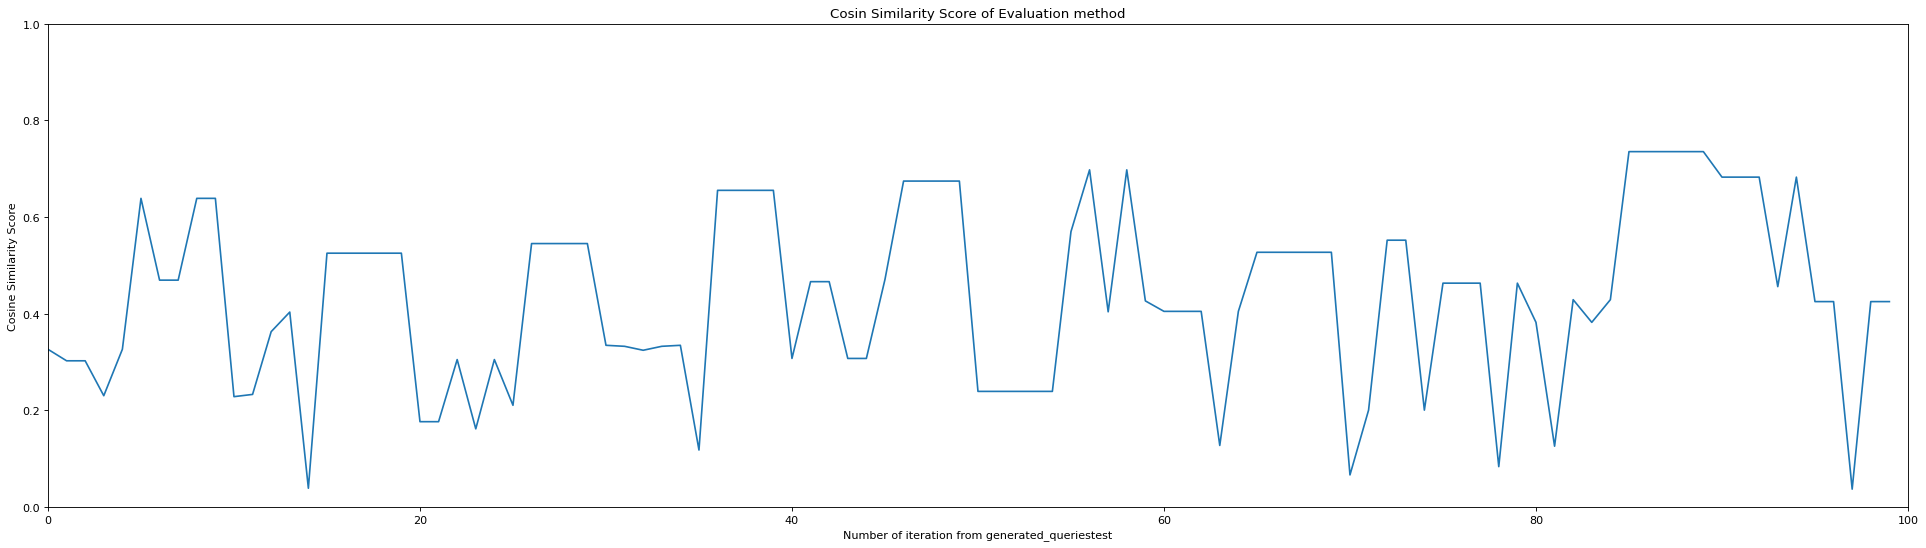

Average Cosine Similarity Score of first 100 iteration: 0.4338067.


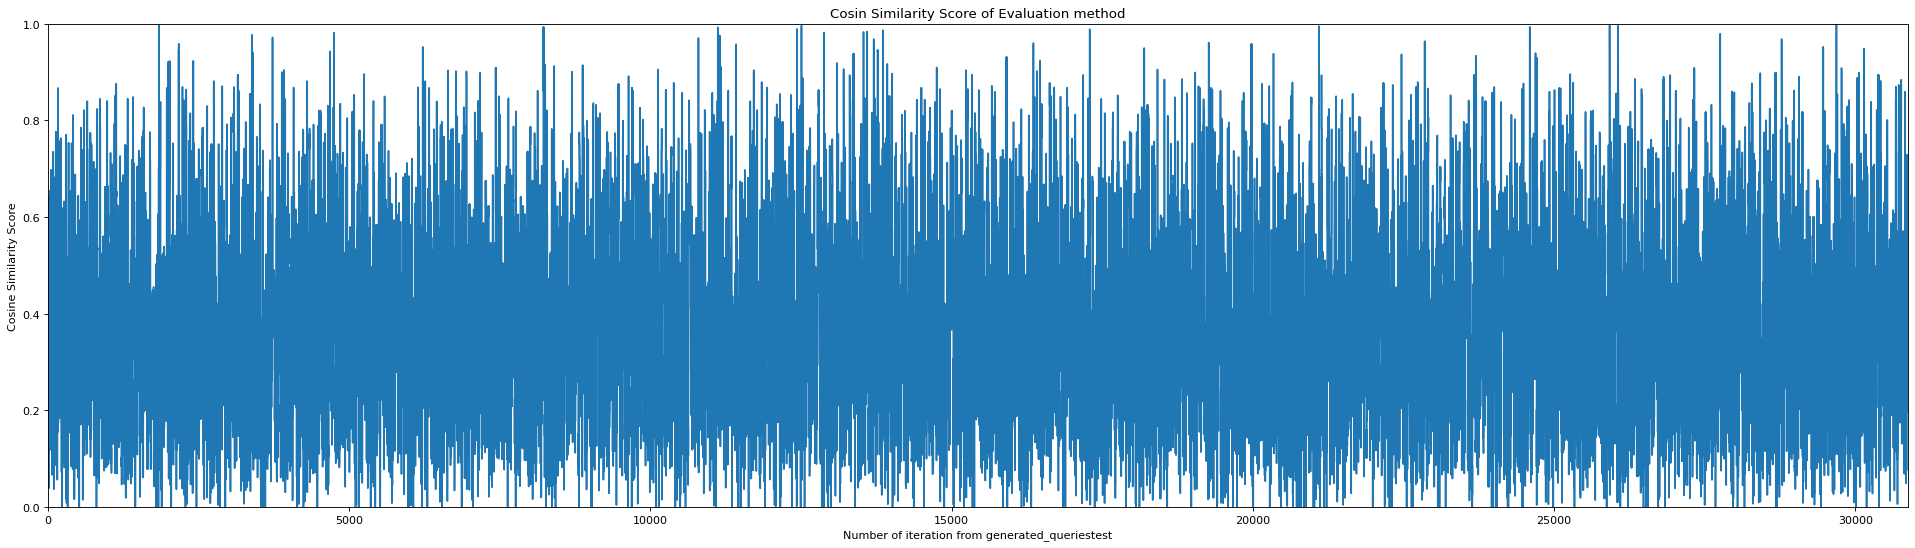

Average Cosine Similarity Score of full iteration: 0.41159652.
min of Data: -0.10681	 the mean of data: 0.41159652	 the max of the Data: 0.99763.


In [ ]:
pltCos,pltDot = plt,plt


pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,100)
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos[:100])
pltCos.show()

average = round(sum(floatOfCos[:100])/100, 8)

print(f"Average Cosine Similarity Score of first 100 iteration: {average}.")
print('='*32)

pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,len(floatOfCos))
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos)
pltCos.show()

average = round(sum(floatOfCos)/len(floatOfCos), 8)

print(f"Average Cosine Similarity Score of full iteration: {average}.")
minData, meanData, maxData = min(floatOfCos),average,max(floatOfCos)
print(f"min of Data: {minData}\t the mean of data: {average}\t the max of the Data: {maxData}.")


print('='*32)
#pltCos.hist(floatOfCos)

# Testing Evaluaton New Method

##msmarco-distilbert-baseV4 with Matplotlab Diagram

In [ ]:
listOfcos = []
listOfdot = []

for i in range(len(testDataFrame)):
  queryEmb = model.encode([testDataFrame['QUESTIONS'][i]], device=torch_device)
  paraEmb = model.encode([testDataFrame['PARAGRAPHS'][i]], device=torch_device)
  top_k = index_emb.search(queryEmb, 1)
  numk = top_k[1][0][0]
  reconEmb = index_emb.reconstruct(int(numk))
  listOfcos.append(util.cos_sim(reconEmb,paraEmb))
  listOfdot.append(util.dot_score(reconEmb,paraEmb))

In [ ]:
floatOfCos = [round(float(x),5) for x in listOfcos]
floatOfDot = [round(float(x),5) for x in listOfdot]

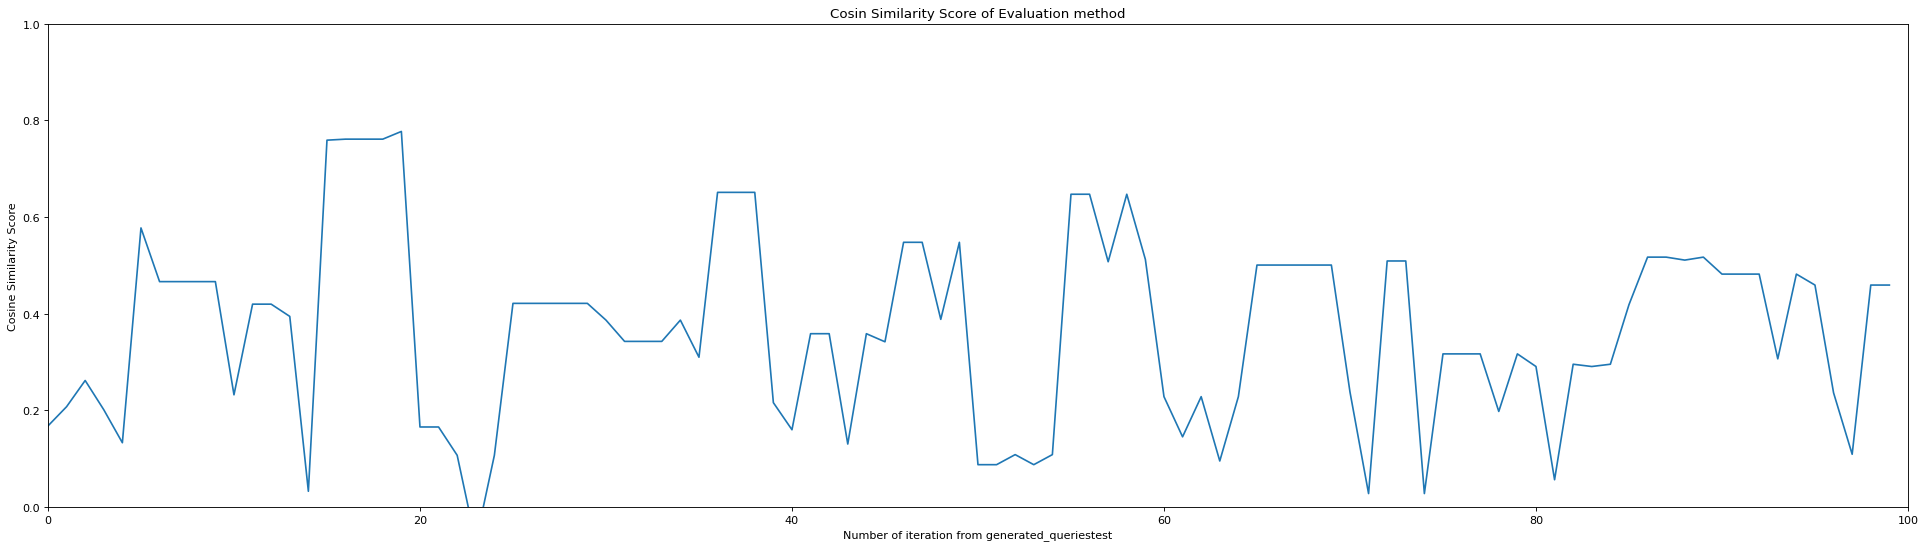

Average Cosine Similarity Score of first 100 iteration: 0.366231.


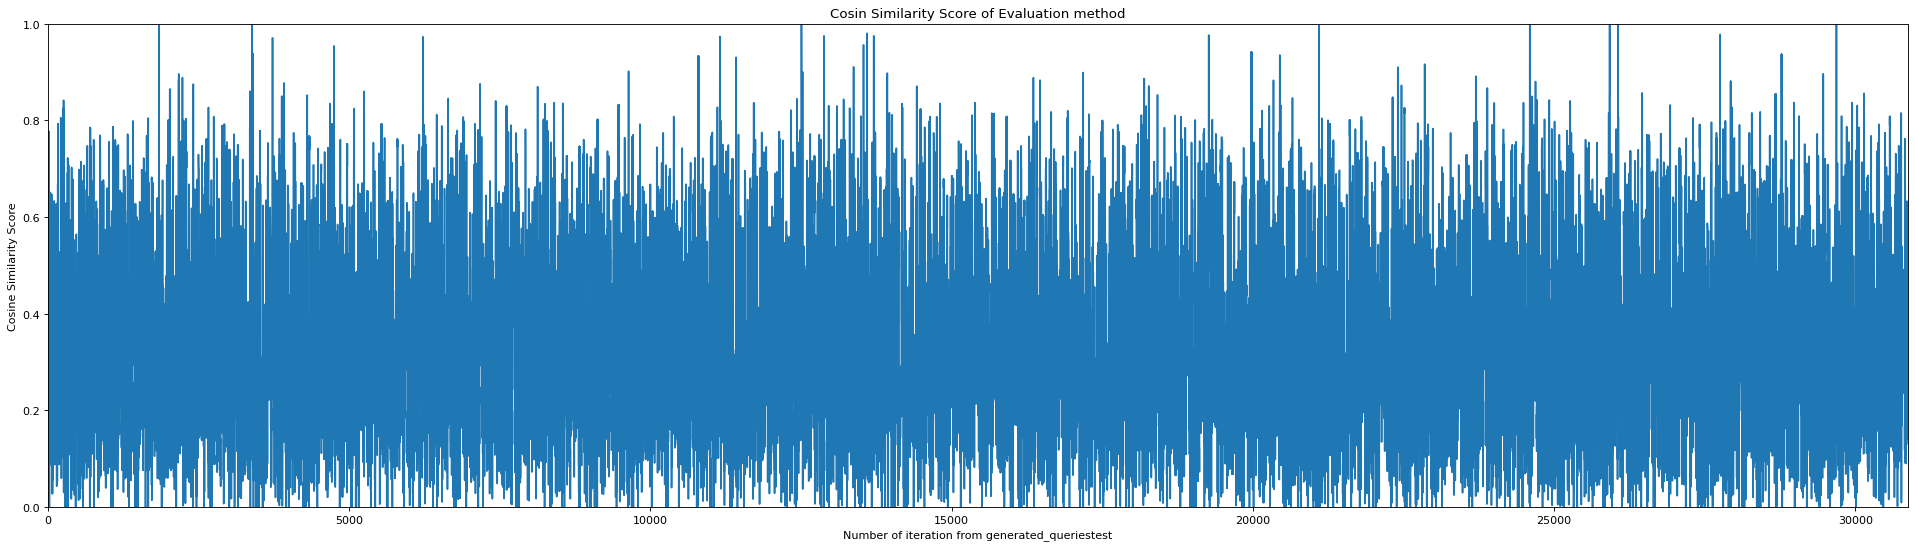

Average Cosine Similarity Score of full iteration: 0.36390248.
min of Data: -0.1618	 the mean of data: 0.36390248	 the max of the Data: 1.0.


In [ ]:
pltCos,pltDot = plt,plt


pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,100)
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos[:100])
pltCos.show()

average = round(sum(floatOfCos[:100])/100, 8)

print(f"Average Cosine Similarity Score of first 100 iteration: {average}.")
print('='*32)

pltCos.figure(figsize=(30, 8), dpi=80)
pltCos.xlim(0,len(floatOfCos))
pltCos.xlabel("Number of iteration from generated_queriestest")
pltCos.ylim(0,1)
pltCos.ylabel('Cosine Similarity Score')
pltCos.title("Cosin Similarity Score of Evaluation method")
pltCos.plot(floatOfCos)
pltCos.show()

average = round(sum(floatOfCos)/len(floatOfCos), 8)

print(f"Average Cosine Similarity Score of full iteration: {average}.")
minData, meanData, maxData = min(floatOfCos),average,max(floatOfCos)
print(f"min of Data: {minData}\t the mean of data: {average}\t the max of the Data: {maxData}.")


print('='*32)
#pltCos.hist(floatOfCos)

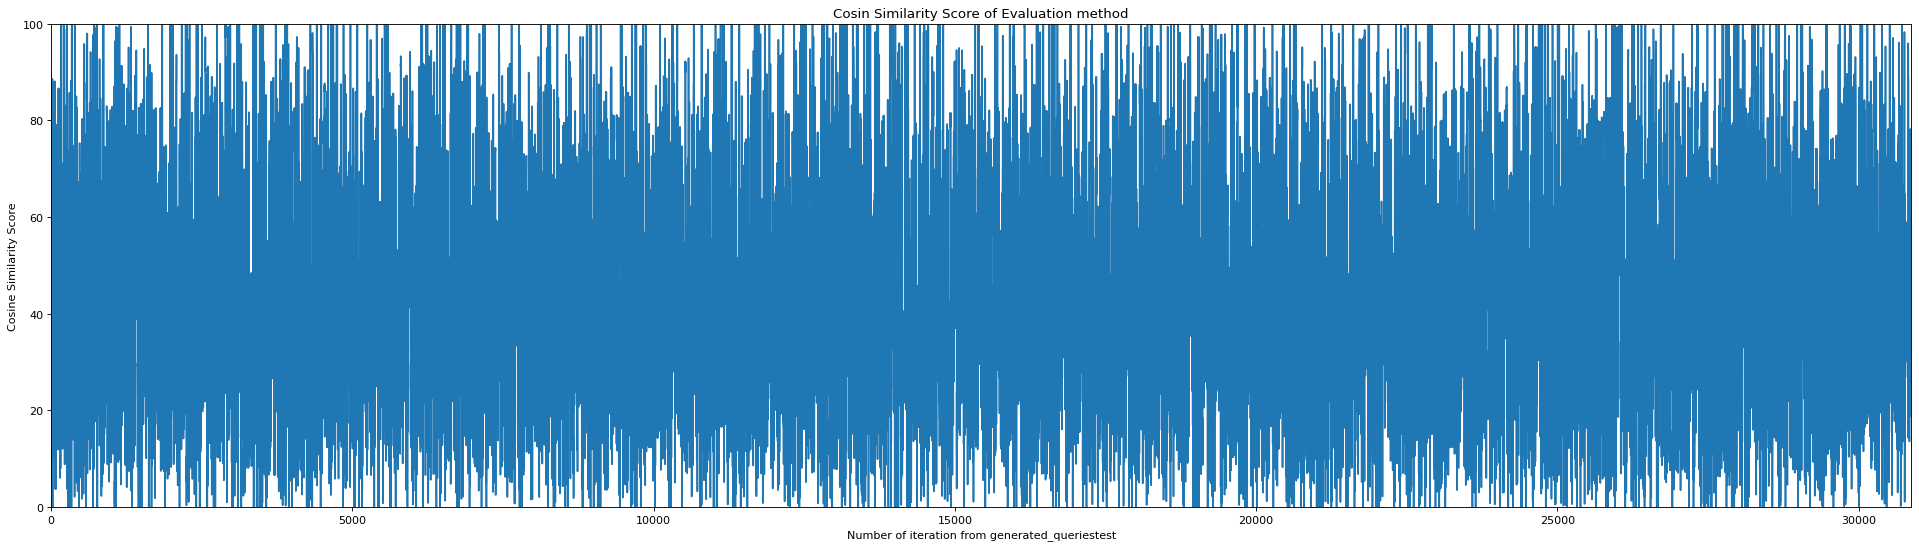

(array([9.0600e+02, 9.5040e+03, 1.0362e+04, 7.1670e+03, 2.4750e+03,
        3.9200e+02, 6.2000e+01, 0.0000e+00, 5.0000e+00, 2.0000e+00]),
 array([-20.37173 ,   6.181225,  32.73418 ,  59.287135,  85.84009 ,
        112.393045, 138.946   , 165.498955, 192.05191 , 218.604865,
        245.15782 ]),
 <a list of 10 Patch objects>)

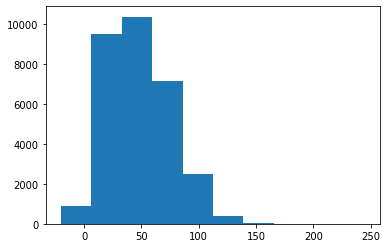

In [ ]:
pltDot.figure(figsize=(30, 8), dpi=80)
pltDot.xlim(0,len(floatOfDot))
pltDot.xlabel("Number of iteration from generated_queriestest")
pltDot.ylim(0,100)
pltDot.ylabel('Cosine Similarity Score')
pltDot.title("Cosin Similarity Score of Evaluation method")
pltDot.plot(floatOfDot)
pltDot.show()

pltDot.hist(floatOfDot)

#TEST SEARCH

In [ ]:
# Example for semantic search
while True:
  query=input('Query: ')
  query_vector = model.encode([query], device=torch_device)
#results=index.search(query_vector, 3)
#print("\n")
#for result in results:
#    print('\t',result)



  top_k = index_emb.search(query_vector, 3)
  locateFile = top_k[1][0]
  filesLoc = [find_data(idx) for idx in locateFile]
  for i in filesLoc:
    print(f"filename: {i['NAME-OF-DOCUMENT']} \n Content: {i['CONTENT'][:100]} \n")
  print('=============================================')

Query: Python
filename: Python-Presentation-dar.pptx 
 Content: [' Introduction to Programming with Python 1 Introduction to Programming with Python Daryll A. CAbag 

filename: Functions.pptx 
 Content: [' Functions Functions By.', 'Jocar Florida Galsim and Johanes Lumantas Guibone WHAT IS A FUNCTION?' 

filename: MIT6_0001F16_Lec2.pdf 
 Content: [' MIT6_0001F16_Branching, Iteration BRANCHING,  ITERATION (download slides and .py files follow alo 



KeyboardInterrupt: ignored